<a href="https://colab.research.google.com/github/paulsubarna/DGM_tutorials-/blob/main/DGM_tutorial_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformer Architectures (Tutorial) — *“Attention Is All You Need”*
This notebook is a hands-on tutorial to understand **Transformer** models, with emphasis on the original paper:

> Vaswani et al., 2017 — *Attention Is All You Need*

You will:
- build intuition for **self-attention**
- implement **scaled dot-product attention** and **multi-head attention**
- understand **positional encodings**
- assemble a **mini Transformer encoder**
- train a tiny model on a toy task
- visualize attention patterns

**Prerequisites:** basic PyTorch, matrix multiplication, softmax.

<img src="transformers.png" width="700" align="center"/>



## 0. Setup
This cell imports packages and sets a reproducible seed.  
If you run on GPU, the notebook will use it automatically.


In [ ]:
import os
os.chdir('/app/src/Tutorial')

In [ ]:

import math
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def set_seed(seed=1337):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(1337)


device: cuda


## 1. Why Transformers?
The original motivation was to replace recurrent sequence models (RNN/LSTM) with something that:
- is **highly parallelizable** (no time-step recurrence),
- can model **long-range dependencies**,
- is stable to optimize at scale.

Key idea: use **attention** as the core computation.

### Paper’s high-level architecture
Transformers are typically composed of:
- **Encoder** stack: processes an input sequence into contextual representations.
- **Decoder** stack: generates output autoregressively, attending to prior outputs and encoder outputs.

In modern language models (GPT-style), we mostly use a *decoder-only* Transformer.  
In translation (original paper), we use *encoder–decoder*.


## 2. Scaled Dot-Product Attention (Core Formula)
In the paper, attention is defined as:

$$
\mathrm{Attention}(Q,K,V) = \mathrm{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

Where:
- **Q** (queries): what each token is looking for
- **K** (keys): what each token offers
- **V** (values): the information to aggregate

The \(\sqrt{d_k}\) scaling prevents logits from exploding when dimensionality grows.


### 2.1 Implement attention from scratch
We implement a function that supports optional **masking** (needed for causal/decoder attention).


In [ ]:

def scaled_dot_product_attention(Q, K, V, mask=None):
    """Q, K, V: (B, H, T, D)  mask: (B, 1, T, T) or (B, H, T, T)"""
    d_k = Q.size(-1)
    scores = (Q @ K.transpose(-2, -1)) / math.sqrt(d_k)  # (B, H, T, T)

    if mask is not None:
        scores = scores.masked_fill(mask == 0, float("-inf"))

    attn = torch.softmax(scores, dim=-1)  # (B, H, T, T)
    out = attn @ V  # (B, H, T, D)
    return out, attn


### 2.2 Quick sanity check
We generate random Q,K,V and ensure shapes match expectations.


In [ ]:

B, H, T, D = 2, 3, 5, 4
Q = torch.randn(B, H, T, D)
K = torch.randn(B, H, T, D)
V = torch.randn(B, H, T, D)

out, attn = scaled_dot_product_attention(Q, K, V)
print("out:", out.shape, "attn:", attn.shape)
print("attn row sums (should be ~1):", attn[0,0,0].sum().item())


out: torch.Size([2, 3, 5, 4]) attn: torch.Size([2, 3, 5, 5])
attn row sums (should be ~1): 1.0


## 3. Multi-Head Attention (MHA)
Instead of doing attention once with a single set of projections, MHA:
- projects inputs into multiple subspaces (**heads**),
- applies attention independently per head,
- concatenates the results and projects back.

In the paper, this improves expressivity and stabilizes training.

### MHA module structure
1. Linear projections: \(XW_Q, XW_K, XW_V\)
2. Split into heads
3. Attention per head
4. Concatenate heads
5. Output projection


### 3.1 Implement Multi-Head Attention in PyTorch
We keep this implementation readable, not micro-optimized.


In [ ]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.0):
        super().__init__()
        assert d_model % n_heads == 0
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model, bias=False)
        self.W_k = nn.Linear(d_model, d_model, bias=False)
        self.W_v = nn.Linear(d_model, d_model, bias=False)
        self.W_o = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x_q, x_kv=None, mask=None, return_attn=False):
        """x_q: (B,T,d_model), x_kv: (B,T,d_model) or None (self-attn)"""
        if x_kv is None:
            x_kv = x_q

        B, Tq, _ = x_q.shape
        _, Tk, _ = x_kv.shape

        Q = self.W_q(x_q)  # (B,Tq,d_model)
        K = self.W_k(x_kv) # (B,Tk,d_model)
        V = self.W_v(x_kv) # (B,Tk,d_model)

        # reshape -> (B,H,T,Dh)
        Q = Q.view(B, Tq, self.n_heads, self.d_head).transpose(1,2)
        K = K.view(B, Tk, self.n_heads, self.d_head).transpose(1,2)
        V = V.view(B, Tk, self.n_heads, self.d_head).transpose(1,2)

        out, attn = scaled_dot_product_attention(Q, K, V, mask=mask)
        out = self.dropout(out)

        # back -> (B,Tq,d_model)
        out = out.transpose(1,2).contiguous().view(B, Tq, self.d_model)
        out = self.W_o(out)

        if return_attn:
            return out, attn
        return out


### 3.2 Test MHA
We run a forward pass to confirm shapes.


In [ ]:

mha = MultiHeadAttention(d_model=32, n_heads=4).to(device)
x = torch.randn(2, 7, 32, device=device)
y, attn = mha(x, return_attn=True)
print("y:", y.shape, "attn:", attn.shape)  # attn: (B,H,T,T)


y: torch.Size([2, 7, 32]) attn: torch.Size([2, 4, 7, 7])


## 4. Positional Encoding
Self-attention by itself is **permutation-invariant**: it doesn’t know token order.

The paper adds **sinusoidal positional encodings**:
$$
PE_{(pos, 2i)} = \sin\left(pos / 10000^{2i/d_{model}}\right),\quad
PE_{(pos, 2i+1)} = \cos\left(pos / 10000^{2i/d_{model}}\right)
$$

Properties:
- gives a unique pattern per position
- allows extrapolation to longer sequences (in principle)
- linear combinations encode relative offsets


### 4.1 Implement sinusoidal positional encodings
We create a tensor of shape (1, T, d_model) that can be added to token embeddings.


In [ ]:

def sinusoidal_positional_encoding(T, d_model, device=None):
    device = device or "cpu"
    pe = torch.zeros(T, d_model, device=device)
    position = torch.arange(0, T, device=device).unsqueeze(1)  # (T,1)
    div_term = torch.exp(torch.arange(0, d_model, 2, device=device) * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # (1,T,d_model)

pe = sinusoidal_positional_encoding(T=64, d_model=32, device=device)
print(pe.shape)


torch.Size([1, 64, 32])


### 4.2 Visualize positional encodings
We plot a small portion of the positional encoding matrix.


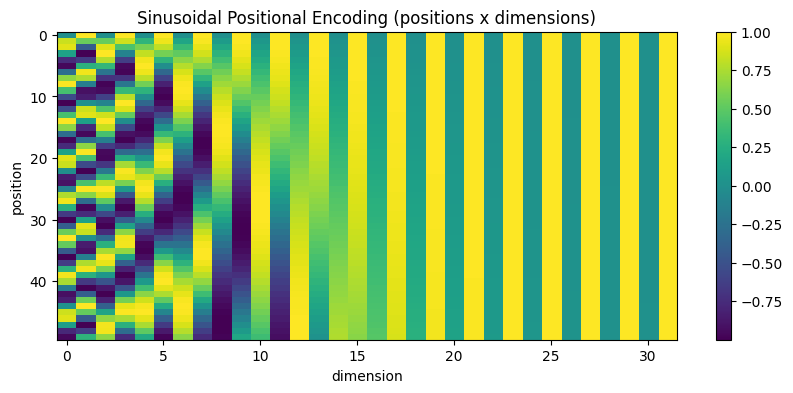

In [ ]:

pe_cpu = pe[0, :50, :32].detach().cpu().numpy()
plt.figure(figsize=(10,4))
plt.imshow(pe_cpu, aspect="auto")
plt.title("Sinusoidal Positional Encoding (positions x dimensions)")
plt.xlabel("dimension")
plt.ylabel("position")
plt.colorbar()
plt.show()


## 5. The Transformer Block (Encoder-style)
A standard encoder block from the paper includes:
1. Multi-head self-attention
2. Add & Norm (residual connection + LayerNorm)
3. Position-wise feed-forward network (FFN)
4. Add & Norm

We'll implement an encoder-style block.

<img src="transformers.png" width="700" align="center"/>


### 5.1 Feed-forward network (FFN)
The paper uses a 2-layer MLP applied independently to each position:
$$
\mathrm{FFN}(x)=\max(0, xW_1 + b_1)W_2 + b_2
$$


In [ ]:

class PositionwiseFFN(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.fc2(self.dropout(F.relu(self.fc1(x))))


### 5.2 Encoder block
We use **pre-LN** (LayerNorm before sublayers), which is common and stable in modern training.
The original paper used post-LN; either is valid, but pre-LN tends to be easier to optimize.


In [ ]:

class TransformerEncoderBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None, return_attn=False):
        if return_attn:
            attn_out, attn = self.mha(self.ln1(x), mask=mask, return_attn=True)
        else:
            attn_out = self.mha(self.ln1(x), mask=mask)
            attn = None
        x = x + self.dropout(attn_out)
        ffn_out = self.ffn(self.ln2(x))
        x = x + self.dropout(ffn_out)
        if return_attn:
            return x, attn
        return x


### 5.3 Mini Encoder model
We build:
- token embedding
- positional encoding
- N encoder blocks
- final LayerNorm
- output head

For a toy task, we can treat this as a sequence model that predicts token labels.


In [ ]:

class MiniTransformerEncoder(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=256, n_layers=2, max_len=2048, dropout=0.0):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len

        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.dropout = nn.Dropout(dropout)
        self.blocks = nn.ModuleList([
            TransformerEncoderBlock(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, idx, mask=None, return_attn=False):
        B, T = idx.shape
        assert T <= self.max_len
        x = self.tok_emb(idx)  # (B,T,d_model)
        x = x + sinusoidal_positional_encoding(T, self.d_model, device=idx.device)
        x = self.dropout(x)

        attn_maps = []
        for blk in self.blocks:
            if return_attn:
                x, attn = blk(x, mask=mask, return_attn=True)
                attn_maps.append(attn)
            else:
                x = blk(x, mask=mask)

        x = self.ln_f(x)
        logits = self.head(x)  # (B,T,vocab)
        if return_attn:
            return logits, attn_maps
        return logits


## 6. Masking (Causal Attention)
For **autoregressive** generation (decoder-only GPT), we need *causal masking* so that position *t* cannot attend to future tokens (*t+1...*).

We construct a lower-triangular mask.


In [ ]:

def causal_mask(T, device=None):
    device = device or "cpu"
    m = torch.tril(torch.ones(T, T, device=device, dtype=torch.uint8))
    return m.unsqueeze(0).unsqueeze(0)  # (1,1,T,T)

m = causal_mask(6, device=device)
print(m.shape)
print(m[0,0])


torch.Size([1, 1, 6, 6])
tensor([[1, 0, 0, 0, 0, 0],
        [1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 1]], device='cuda:0', dtype=torch.uint8)


## 7. Next-token Prediction
We will train a tiny Transformer-like model to learn a simple pattern.

Task:
- sample random sequences of integers from a small vocabulary
- train the model to predict the **next token** (language-model objective)

This is not a real NLP task, but it’s perfect for debugging and understanding.


### 7.1 Create toy data generator
We generate random sequences and train next-token prediction.


In [ ]:

def generate_batch(batch_size, seq_len, vocab_size, device):
    x = torch.randint(0, vocab_size, (batch_size, seq_len), device=device)
    y = torch.roll(x, shifts=-1, dims=1)  # next token (wrap-around)
    y[:, -1] = 0
    return x, y


### 7.2 Train a small model
We use:
- causal mask
- cross entropy loss
- Adam optimizer

You should see loss go down quickly.


In [ ]:

vocab_size = 128
model = MiniTransformerEncoder(vocab_size=vocab_size, d_model=128, n_heads=4, d_ff=256, n_layers=2, max_len=2048, dropout=0.0).to(device)
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

seq_len = 64
steps = 300
losses = []

model.train()
for step in range(steps):
    x, y = generate_batch(batch_size=64, seq_len=seq_len, vocab_size=vocab_size, device=device)
    mask = causal_mask(seq_len, device=device)

    logits = model(x, mask=mask)  # (B,T,V)
    loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()

    losses.append(loss.item())
    if (step + 1) % 50 == 0:
        print(f"step {step+1}/{steps} | loss {loss.item():.4f} | ppl {math.exp(loss.item()):.2f}")


step 50/300 | loss 4.8466 | ppl 127.31
step 100/300 | loss 4.8242 | ppl 124.49
step 150/300 | loss 4.7939 | ppl 120.77
step 200/300 | loss 4.7848 | ppl 119.68
step 250/300 | loss 4.7814 | ppl 119.28
step 300/300 | loss 4.7809 | ppl 119.21


### 7.3 Plot the training loss


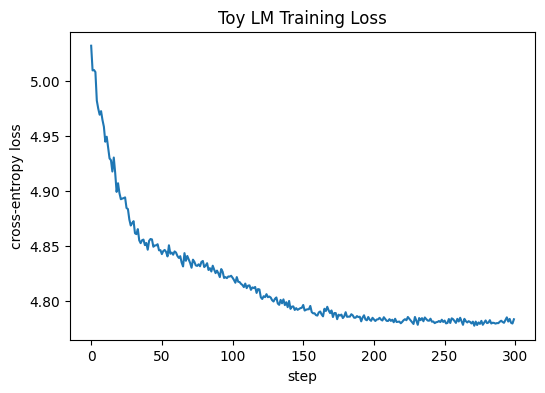

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Toy LM Training Loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.show()


## 8. Visualizing Attention Maps
Attention maps help build intuition:
- Rows correspond to **query** positions
- Columns correspond to **key** positions
- Values represent attention weights

We’ll run a forward pass and visualize one head from one layer.


### 8.1 Run a batch and extract attention


In [ ]:

model.eval()
x, y = generate_batch(batch_size=1, seq_len=32, vocab_size=vocab_size, device=device)
mask = causal_mask(32, device=device)

logits, attn_maps = model(x, mask=mask, return_attn=True)

print("num layers:", len(attn_maps))
print("layer 0 attn shape:", attn_maps[0].shape)  # (B,H,T,T)


num layers: 2
layer 0 attn shape: torch.Size([1, 4, 32, 32])


### 8.2 Plot one head's attention matrix


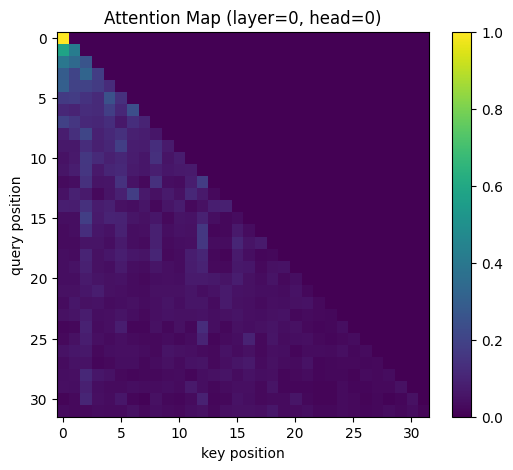

In [ ]:

layer = 0
head = 0
A = attn_maps[layer][0, head].detach().cpu().numpy()

plt.figure(figsize=(6,5))
plt.imshow(A, aspect="auto")
plt.title(f"Attention Map (layer={layer}, head={head})")
plt.xlabel("key position")
plt.ylabel("query position")
plt.colorbar()
plt.show()


<img src="Feature_attribution.png" width="700" align="center"/>


## 9. Connecting Back to *Attention Is All You Need*
Let’s map what we implemented to the original paper components:


### Paper’s encoder-decoder vs this notebook
- The paper uses encoder-decoder for translation.
- For GPT-style models, you use a stack of **masked self-attention** blocks (decoder-only).

### Notes for real training
For real language modeling, you additionally need:
- a real tokenizer + dataset pipeline
- efficient packed batches (no padding waste)
- long training runs and LR schedules
- careful eval (perplexity on held-out set)


## 10. Why LayerNorm? Understanding Normalization in Transformers

You might have noticed `nn.LayerNorm` appears everywhere in our Transformer blocks. Let's understand why it's essential.

### The Problem: Internal Covariate Shift
During training, as weights update, the distribution of inputs to each layer keeps changing. This makes training unstable and slow, especially in deep networks.

### What LayerNorm Does
Layer Normalization normalizes across the **feature dimension** for each sample independently:

For input $x \in \mathbb{R}^{d}$:
$$
\text{LayerNorm}(x) = \gamma \odot \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}} + \beta
$$

Where:
- $\mu = \frac{1}{d}\sum_{i=1}^d x_i$ (mean across features)
- $\sigma^2 = \frac{1}{d}\sum_{i=1}^d (x_i - \mu)^2$ (variance across features)
- $\gamma, \beta$ are learnable scale and shift parameters
- $\epsilon$ is a small constant for numerical stability

### Why Transformers Need LayerNorm

1. **Stabilizes training**: Prevents activation explosions/vanishing in deep networks
2. **Enables higher learning rates**: Normalized gradients allow faster convergence
3. **Reduces sensitivity to initialization**: Network trains reliably from different starts
4. **Works with variable sequence lengths**: Unlike BatchNorm, doesn't depend on batch statistics

### Pre-LN vs Post-LN
- **Post-LN** (original paper): LayerNorm after sublayer `x + LayerNorm(Sublayer(x))`
- **Pre-LN** (modern): LayerNorm before sublayer `x + Sublayer(LayerNorm(x))`
- Pre-LN is more stable and easier to train, which is why we use it in this notebook


### Visualizing LayerNorm Effect

Let's see how LayerNorm affects activations during training.


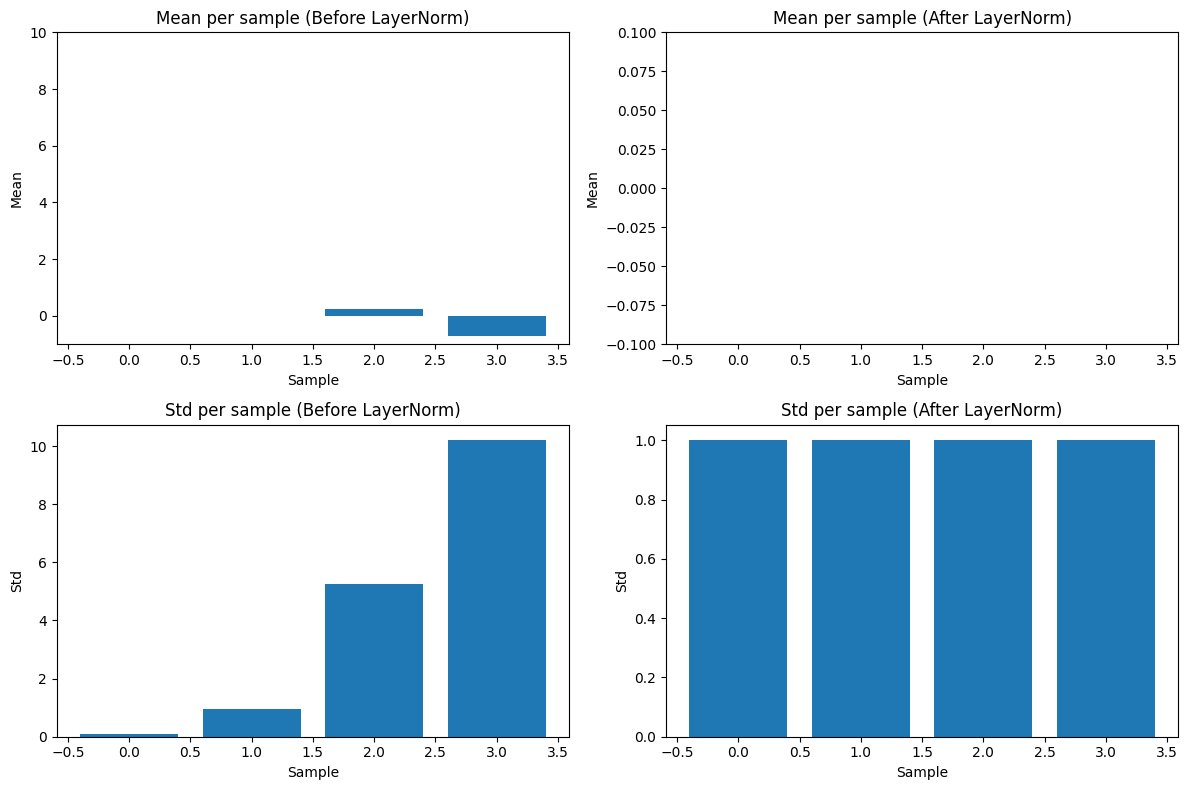

Before LayerNorm:
  Mean range: [-0.720, 0.259]
  Std range:  [0.099, 10.220]

After LayerNorm:
  Mean range: [-0.000000, 0.000000]
  Std range:  [1.001, 1.002]

✓ LayerNorm makes statistics consistent across samples!


In [ ]:

# Simulate activations before and after LayerNorm
torch.manual_seed(42)

# Create sample activations with varying scales (simulating deep network issues)
batch_size, seq_len, d_model = 4, 8, 32
x = torch.randn(batch_size, seq_len, d_model) * torch.tensor([0.1, 1.0, 5.0, 10.0]).view(4, 1, 1)

# Apply LayerNorm
ln = nn.LayerNorm(d_model)
x_normalized = ln(x)

# Visualize statistics
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Before LayerNorm - Mean per sample
axes[0, 0].bar(range(batch_size), x.mean(dim=(1, 2)).numpy())
axes[0, 0].set_title("Mean per sample (Before LayerNorm)")
axes[0, 0].set_xlabel("Sample")
axes[0, 0].set_ylabel("Mean")
axes[0, 0].set_ylim(-1, 10)

# After LayerNorm - Mean per sample
axes[0, 1].bar(range(batch_size), x_normalized.mean(dim=(1, 2)).detach().numpy())
axes[0, 1].set_title("Mean per sample (After LayerNorm)")
axes[0, 1].set_xlabel("Sample")
axes[0, 1].set_ylabel("Mean")
axes[0, 1].set_ylim(-0.1, 0.1)

# Before LayerNorm - Std per sample
axes[1, 0].bar(range(batch_size), x.std(dim=(1, 2)).numpy())
axes[1, 0].set_title("Std per sample (Before LayerNorm)")
axes[1, 0].set_xlabel("Sample")
axes[1, 0].set_ylabel("Std")

# After LayerNorm - Std per sample
axes[1, 1].bar(range(batch_size), x_normalized.std(dim=(1, 2)).detach().numpy())
axes[1, 1].set_title("Std per sample (After LayerNorm)")
axes[1, 1].set_xlabel("Sample")
axes[1, 1].set_ylabel("Std")

plt.tight_layout()
plt.show()

print("Before LayerNorm:")
print(f"  Mean range: [{x.mean(dim=(1,2)).min():.3f}, {x.mean(dim=(1,2)).max():.3f}]")
print(f"  Std range:  [{x.std(dim=(1,2)).min():.3f}, {x.std(dim=(1,2)).max():.3f}]")
print("\nAfter LayerNorm:")
print(f"  Mean range: [{x_normalized.mean(dim=(1,2)).min():.6f}, {x_normalized.mean(dim=(1,2)).max():.6f}]")
print(f"  Std range:  [{x_normalized.std(dim=(1,2)).min():.3f}, {x_normalized.std(dim=(1,2)).max():.3f}]")
print("\n✓ LayerNorm makes statistics consistent across samples!")



### Training Comparison: With vs Without LayerNorm

Let's train two small models to see the impact of LayerNorm.


In [ ]:

# Model WITHOUT LayerNorm
class TransformerBlockNoLN(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.0):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # No LayerNorm!
        x = x + self.dropout(self.mha(x, mask=mask))
        x = x + self.dropout(self.ffn(x))
        return x

# Model WITH LayerNorm (same as TransformerEncoderBlock but simplified)
class TransformerBlockWithLN(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # With LayerNorm (Pre-LN)
        x = x + self.dropout(self.mha(self.ln1(x), mask=mask))
        x = x + self.dropout(self.ffn(self.ln2(x)))
        return x

# Simple model for comparison
class SimpleLM(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, d_ff, n_layers, use_ln=True):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model)
        BlockClass = TransformerBlockWithLN if use_ln else TransformerBlockNoLN
        self.blocks = nn.ModuleList([
            BlockClass(d_model, n_heads, d_ff, dropout=0.0)
            for _ in range(n_layers)
        ])
        self.head = nn.Linear(d_model, vocab_size)

    def forward(self, idx, mask=None):
        x = self.emb(idx)
        for blk in self.blocks:
            x = blk(x, mask=mask)
        return self.head(x)

# Train both models
vocab_size_compare = 64
d_model_compare = 64
steps_compare = 200

print("Training models...")
results = {}

for use_ln, name in [(True, "With LayerNorm"), (False, "Without LayerNorm")]:
    model_compare = SimpleLM(vocab_size_compare, d_model_compare, n_heads=4,
                              d_ff=128, n_layers=3, use_ln=use_ln).to(device)
    opt_compare = torch.optim.Adam(model_compare.parameters(), lr=3e-4)

    losses_compare = []
    model_compare.train()

    for step in range(steps_compare):
        x, y = generate_batch(32, 16, vocab_size_compare, device)
        mask = causal_mask(16, device)

        logits = model_compare(x, mask=mask)
        loss = F.cross_entropy(logits.view(-1, vocab_size_compare), y.view(-1))

        opt_compare.zero_grad(set_to_none=True)
        loss.backward()

        # Check for exploding gradients
        grad_norm = torch.nn.utils.clip_grad_norm_(model_compare.parameters(), 1.0)

        opt_compare.step()
        losses_compare.append(loss.item())

        if (step + 1) % 50 == 0:
            print(f"{name} - step {step+1}/{steps_compare} | loss {loss:.4f} | grad_norm {grad_norm:.4f}")

    results[name] = losses_compare

# Plot comparison
plt.figure(figsize=(10, 5))
for name, losses_list in results.items():
    plt.plot(losses_list, label=name, linewidth=2)
plt.title("Training Stability: With vs Without LayerNorm")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n" + "="*60)
print("COMPARISON SUMMARY:")
print("="*60)
for name, losses_list in results.items():
    final_loss = losses_list[-10:]
    print(f"{name}:")
    print(f"  Final loss (avg last 10): {np.mean(final_loss):.4f}")
    print(f"  Loss variance: {np.var(losses_list):.4f}")
    print(f"  Min loss: {min(losses_list):.4f}")



# 11. Full Encoder–Decoder Transformer (Seq2Seq)
So far we built the **core blocks** (self-attention, multi-head attention, positional encodings, FFN) and a small **encoder-style** model.

The original paper, however, uses a **full encoder–decoder** architecture for machine translation:

- **Encoder**: self-attention over the *source* sequence
- **Decoder**: (1) **masked** self-attention over previously generated target tokens, then (2) **cross-attention** over the encoder outputs

In this section we will:
1) implement **cross-attention** (already supported by our `MultiHeadAttention` via `x_q` vs `x_kv`),
2) build an **Encoder** stack and a **Decoder** stack,
3) train on a **toy translation** dataset (sequence reversal) using teacher forcing,
4) perform **greedy decoding** to see the model translate.


## 11.1 Cross-attention refresher
Cross-attention uses:
- queries from the decoder hidden states (what the decoder wants),
- keys/values from the encoder outputs (what the source provides).

Formally, it is the same attention formula, just with different inputs:
$$
\mathrm{Attention}(Q_{\text{dec}}, K_{\text{enc}}, V_{\text{enc}})
$$

We already implemented this capability in `MultiHeadAttention.forward(x_q, x_kv=...)`.


## 11.2 Building blocks: Encoder layer and Decoder layer
Below we implement:
- `TransformerEncoderLayer`: self-attention + FFN
- `TransformerDecoderLayer`: masked self-attention + cross-attention + FFN

We use **pre-LN** (LayerNorm before each sublayer) for stability.


In [ ]:

# Encoder/Decoder layers using the previously defined modules:
# - MultiHeadAttention
# - PositionwiseFFN
# - causal_mask
# - sinusoidal_positional_encoding

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask=None, return_attn=False):
        if return_attn:
            sa_out, sa_attn = self.self_attn(self.ln1(x), mask=src_mask, return_attn=True)
        else:
            sa_out = self.self_attn(self.ln1(x), mask=src_mask)
            sa_attn = None
        x = x + self.dropout(sa_out)
        x = x + self.dropout(self.ffn(self.ln2(x)))
        if return_attn:
            return x, sa_attn
        return x


class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, n_heads, d_ff, dropout=0.0):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.ln3 = nn.LayerNorm(d_model)
        self.self_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.cross_attn = MultiHeadAttention(d_model, n_heads, dropout=dropout)
        self.ffn = PositionwiseFFN(d_model, d_ff, dropout=dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, enc_out, tgt_mask=None, src_mask=None, return_attn=False):
        # 1) masked self-attention over decoder tokens
        if return_attn:
            sa_out, sa_attn = self.self_attn(self.ln1(x), mask=tgt_mask, return_attn=True)
        else:
            sa_out = self.self_attn(self.ln1(x), mask=tgt_mask)
            sa_attn = None
        x = x + self.dropout(sa_out)

        # 2) cross-attention: queries from decoder, keys/values from encoder
        if return_attn:
            ca_out, ca_attn = self.cross_attn(self.ln2(x), x_kv=enc_out, mask=src_mask, return_attn=True)
        else:
            ca_out = self.cross_attn(self.ln2(x), x_kv=enc_out, mask=src_mask)
            ca_attn = None
        x = x + self.dropout(ca_out)

        # 3) FFN
        x = x + self.dropout(self.ffn(self.ln3(x)))

        if return_attn:
            return x, sa_attn, ca_attn
        return x


## 11.3 Full Encoder–Decoder model
We implement a minimal seq2seq Transformer:
- token embeddings for source and target
- sinusoidal positional encodings
- encoder stack
- decoder stack
- output projection to vocabulary

We will keep one shared vocabulary for simplicity in the toy task.


In [ ]:

class TransformerSeq2Seq(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=256,
                 n_layers=2, max_len=256, dropout=0.0, tie_embeddings=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len

        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.tgt_emb = nn.Embedding(vocab_size, d_model)
        self.drop = nn.Dropout(dropout)

        self.encoder = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.decoder = nn.ModuleList([
            TransformerDecoderLayer(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.ln_enc = nn.LayerNorm(d_model)
        self.ln_dec = nn.LayerNorm(d_model)
        self.out = nn.Linear(d_model, vocab_size, bias=False)

        if tie_embeddings:
            self.out.weight = self.tgt_emb.weight

    def encode(self, src, src_mask=None):
        B, Ts = src.shape
        assert Ts <= self.max_len
        x = self.src_emb(src) + sinusoidal_positional_encoding(Ts, self.d_model, device=src.device)
        x = self.drop(x)
        for layer in self.encoder:
            x = layer(x, src_mask=src_mask)
        return self.ln_enc(x)

    def decode(self, tgt, enc_out, tgt_mask=None, src_mask=None):
        B, Tt = tgt.shape
        assert Tt <= self.max_len
        x = self.tgt_emb(tgt) + sinusoidal_positional_encoding(Tt, self.d_model, device=tgt.device)
        x = self.drop(x)
        for layer in self.decoder:
            x = layer(x, enc_out, tgt_mask=tgt_mask, src_mask=src_mask)
        x = self.ln_dec(x)
        logits = self.out(x)
        return logits

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        enc_out = self.encode(src, src_mask=src_mask)
        logits = self.decode(tgt, enc_out, tgt_mask=tgt_mask, src_mask=src_mask)
        return logits


## 12. Toy Translation Task: Reverse the Sequence
We now create a toy “translation” dataset:
- **Source**: a sequence of integers (tokens)
- **Target**: the **reversed** source sequence

We also include special tokens:
- `PAD = 0`
- `BOS = 1`
- `EOS = 2`
- content tokens start at 3


### 12.1 Data generation
Each training example:
- choose random length `L`
- sample tokens in `[3, vocab_size)`
- source: `[tok1 ... tokL]`
- target: `[BOS tokL ... tok1 EOS]` padded to fixed length


In [ ]:

PAD, BOS, EOS = 0, 1, 2

def make_reverse_batch(batch_size, max_len, vocab_size, device):
    src = torch.full((batch_size, max_len), PAD, device=device, dtype=torch.long)
    tgt = torch.full((batch_size, max_len + 2), PAD, device=device, dtype=torch.long)

    for i in range(batch_size):
        L = random.randint(4, max_len)
        tokens = torch.randint(3, vocab_size, (L,), device=device)
        src[i, :L] = tokens
        rev = torch.flip(tokens, dims=[0])
        tgt_seq = torch.cat([torch.tensor([BOS], device=device), rev, torch.tensor([EOS], device=device)])
        tgt[i, :tgt_seq.numel()] = tgt_seq

    return src, tgt

src, tgt = make_reverse_batch(batch_size=2, max_len=10, vocab_size=64, device=device)
print("src:\n", src)
print("tgt:\n", tgt)


src:
 tensor([[20, 12, 53, 14, 55, 22, 28,  6,  0,  0],
        [33, 26, 38, 52,  6,  7, 26, 30,  0,  0]], device='cuda:0')
tgt:
 tensor([[ 1,  6, 28, 22, 55, 14, 53, 12, 20,  2,  0,  0],
        [ 1, 30, 26,  7,  6, 52, 38, 26, 33,  2,  0,  0]], device='cuda:0')


### 12.2 Masks: padding + causality
We need:
- padding masks to ignore PAD tokens
- causal mask for decoder self-attention


In [ ]:

def padding_mask(seq, pad_id=0):
    # (B,T) -> (B,1,1,T)
    return (seq != pad_id).unsqueeze(1).unsqueeze(2).to(torch.uint8)

def expand_kv_mask_to_attn(mask_kv, Tq):
    # (B,1,1,Tk) -> (B,1,Tq,Tk)
    return mask_kv.expand(-1, -1, Tq, -1)

B = src.size(0)
Ts = src.size(1)
Tt = tgt.size(1)

src_pad = padding_mask(src, PAD)                         # (B,1,1,Ts)
src_mask_enc = expand_kv_mask_to_attn(src_pad, Tq=Ts)    # (B,1,Ts,Ts)

tgt_in = tgt[:, :-1]
tgt_pad = padding_mask(tgt_in, PAD)                      # (B,1,1,Tt-1)
tgt_causal = causal_mask(tgt_in.size(1), device=device)  # (1,1,Tt-1,Tt-1)
tgt_self_mask = tgt_causal & expand_kv_mask_to_attn(tgt_pad, Tq=tgt_in.size(1))  # (B,1,Tt-1,Tt-1)

src_mask_dec = expand_kv_mask_to_attn(src_pad, Tq=tgt_in.size(1))  # (B,1,Tt-1,Ts)

print("src_mask_enc:", src_mask_enc.shape)
print("tgt_self_mask:", tgt_self_mask.shape)
print("src_mask_dec:", src_mask_dec.shape)


src_mask_enc: torch.Size([2, 1, 10, 10])
tgt_self_mask: torch.Size([2, 1, 11, 11])
src_mask_dec: torch.Size([2, 1, 11, 10])


## 13. Training loop
We train with:
- decoder input `tgt_in = tgt[:, :-1]`
- targets `tgt_out = tgt[:, 1:]`
- cross-entropy loss with `ignore_index=PAD`


In [ ]:

vocab_size = 64
d_model = 128
n_heads = 4
d_ff = 256
n_layers = 2
max_content_len = 16
dropout = 0.0

seq2seq = TransformerSeq2Seq(
    vocab_size=vocab_size,
    d_model=d_model,
    n_heads=n_heads,
    d_ff=d_ff,
    n_layers=n_layers,
    max_len=max_content_len + 2,
    dropout=dropout,
    tie_embeddings=True
).to(device)

opt = torch.optim.Adam(seq2seq.parameters(), lr=3e-4)
print("params:", sum(p.numel() for p in seq2seq.parameters())/1e6, "M")


params: 0.676352 M


In [ ]:

def seq2seq_step(model, opt, batch_size=64, max_len=16, vocab_size=64, device="cpu"):
    model.train()
    src, tgt = make_reverse_batch(batch_size, max_len, vocab_size, device=device)

    Ts = src.size(1)

    tgt_in = tgt[:, :-1]
    tgt_out = tgt[:, 1:]

    # masks
    src_pad = padding_mask(src, PAD)
    src_mask_enc = expand_kv_mask_to_attn(src_pad, Tq=Ts)

    tgt_pad = padding_mask(tgt_in, PAD)
    tgt_causal = causal_mask(tgt_in.size(1), device=device)
    tgt_self_mask = tgt_causal & expand_kv_mask_to_attn(tgt_pad, Tq=tgt_in.size(1))

    # encode with encoder mask, decode with only decoder mask (no cross-attention mask needed for toy task)
    enc_out = model.encode(src, src_mask=src_mask_enc)
    logits = model.decode(tgt_in, enc_out, tgt_mask=tgt_self_mask, src_mask=None)

    loss = F.cross_entropy(
        logits.reshape(-1, vocab_size),
        tgt_out.reshape(-1),
        ignore_index=PAD
    )

    opt.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    opt.step()
    return loss.item()

# quick check
print("one step loss:", seq2seq_step(seq2seq, opt, batch_size=16, max_len=max_content_len, vocab_size=vocab_size, device=device))



one step loss: 100.31219482421875


In [ ]:

steps = 600
losses = []
for s in range(steps):
    loss = seq2seq_step(seq2seq, opt, batch_size=64, max_len=max_content_len, vocab_size=vocab_size, device=device)
    losses.append(loss)
    if (s + 1) % 100 == 0:
        print(f"step {s+1}/{steps} | loss {loss:.4f} | ppl {math.exp(loss):.2f}")


step 100/600 | loss 4.2040 | ppl 66.95
step 200/600 | loss 4.0991 | ppl 60.29
step 300/600 | loss 3.8587 | ppl 47.40
step 400/600 | loss 3.4893 | ppl 32.76
step 500/600 | loss 3.3038 | ppl 27.22
step 600/600 | loss 3.0366 | ppl 20.83


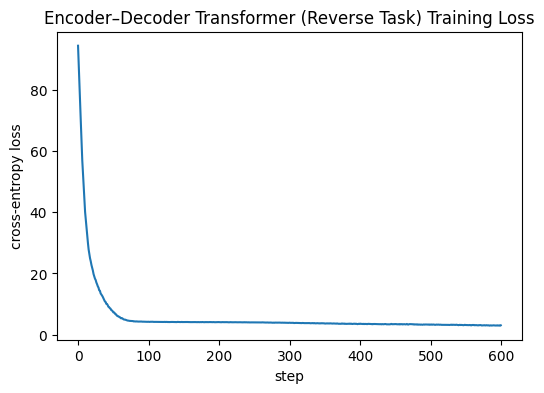

In [ ]:

plt.figure(figsize=(6,4))
plt.plot(losses)
plt.title("Encoder–Decoder Transformer (Reverse Task) Training Loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.show()


## 14. Greedy decoding
We encode the source, then iteratively decode from `BOS` until `EOS` or a max length.


In [ ]:

@torch.no_grad()
def greedy_decode(model, src, max_new_tokens=32):
    model.eval()
    B, Ts = src.shape

    src_pad = padding_mask(src, PAD)
    src_mask_enc = expand_kv_mask_to_attn(src_pad, Tq=Ts)
    enc_out = model.encode(src, src_mask=src_mask_enc)

    ys = torch.full((B, 1), BOS, device=src.device, dtype=torch.long)

    for _ in range(max_new_tokens):
        Tt = ys.size(1)
        tgt_pad = padding_mask(ys, PAD)
        tgt_causal = causal_mask(Tt, device=src.device)
        tgt_self_mask = tgt_causal & expand_kv_mask_to_attn(tgt_pad, Tq=Tt)

        logits = model.decode(ys, enc_out, tgt_mask=tgt_self_mask, src_mask=None)
        next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
        ys = torch.cat([ys, next_token], dim=1)

        if torch.all(next_token.squeeze(-1) == EOS):
            break

    return ys

src, tgt = make_reverse_batch(batch_size=1, max_len=max_content_len, vocab_size=vocab_size, device=device)
pred = greedy_decode(seq2seq, src, max_new_tokens=max_content_len + 2)

print("SRC:", src[0].tolist())
print("TGT (gold):", tgt[0].tolist())
print("PRED:", pred[0].tolist())


SRC: [23, 37, 62, 29, 56, 54, 15, 31, 37, 31, 15, 23, 0, 0, 0, 0]
TGT (gold): [1, 23, 15, 31, 37, 31, 15, 54, 56, 29, 62, 37, 23, 2, 0, 0, 0, 0]
PRED: [1, 23, 23, 23, 23, 23, 23, 23, 37, 37, 37, 37, 37, 2]


## 15. Improving the Model Performance
The model shows repetitive behavior and doesn't reverse properly. Here are key improvements:

Let's implement these improvements:


In [ ]:

# Improved configuration
vocab_size_improved = 64
d_model_improved = 256  # increased from 128
n_heads_improved = 8    # increased from 4
d_ff_improved = 512     # increased from 256
n_layers_improved = 4   # increased from 2
max_content_len_improved = 16
dropout_improved = 0.1  # added dropout

seq2seq_improved = TransformerSeq2Seq(
    vocab_size=vocab_size_improved,
    d_model=d_model_improved,
    n_heads=n_heads_improved,
    d_ff=d_ff_improved,
    n_layers=n_layers_improved,
    max_len=max_content_len_improved + 2,
    dropout=dropout_improved,
    tie_embeddings=True
).to(device)

# Learning rate with warmup
def get_lr(step, warmup_steps=400, d_model=256):
    """Learning rate schedule with warmup"""
    return (d_model ** -0.5) * min((step + 1) ** -0.5, (step + 1) * warmup_steps ** -1.5)

opt_improved = torch.optim.Adam(seq2seq_improved.parameters(), lr=1.0, betas=(0.9, 0.98), eps=1e-9)

print("params:", sum(p.numel() for p in seq2seq_improved.parameters())/1e6, "M")



params: 5.293056 M


In [ ]:

# Improved training loop with LR schedule and proper masking
steps_improved = 2000
losses_improved = []

seq2seq_improved.train()
for s in range(steps_improved):
    # Update learning rate
    lr = get_lr(s, warmup_steps=400, d_model=d_model_improved)
    for param_group in opt_improved.param_groups:
        param_group['lr'] = lr

    # Generate batch
    src, tgt = make_reverse_batch(batch_size=128, max_len=max_content_len_improved, vocab_size=vocab_size_improved, device=device)

    Ts = src.size(1)
    tgt_in = tgt[:, :-1]
    tgt_out = tgt[:, 1:]

    # Proper masks
    src_pad = padding_mask(src, PAD)
    src_mask_enc = expand_kv_mask_to_attn(src_pad, Tq=Ts)

    tgt_pad = padding_mask(tgt_in, PAD)
    tgt_causal = causal_mask(tgt_in.size(1), device=device)
    tgt_self_mask = tgt_causal & expand_kv_mask_to_attn(tgt_pad, Tq=tgt_in.size(1))

    # Encode and decode
    enc_out = seq2seq_improved.encode(src, src_mask=src_mask_enc)
    logits = seq2seq_improved.decode(tgt_in, enc_out, tgt_mask=tgt_self_mask, src_mask=None)

    # Loss with label smoothing
    loss = F.cross_entropy(
        logits.reshape(-1, vocab_size_improved),
        tgt_out.reshape(-1),
        ignore_index=PAD,
        label_smoothing=0.1
    )

    opt_improved.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(seq2seq_improved.parameters(), 1.0)
    opt_improved.step()

    losses_improved.append(loss.item())
    if (s + 1) % 200 == 0:
        print(f"step {s+1}/{steps_improved} | loss {loss:.4f} | ppl {math.exp(loss):.2f} | lr {lr:.6f}")



step 200/2000 | loss 4.4061 | ppl 81.95 | lr 0.001563
step 400/2000 | loss 2.0463 | ppl 7.74 | lr 0.003125
step 600/2000 | loss 1.2747 | ppl 3.58 | lr 0.002552
step 800/2000 | loss 0.9838 | ppl 2.67 | lr 0.002210
step 1000/2000 | loss 0.8625 | ppl 2.37 | lr 0.001976
step 1200/2000 | loss 0.8397 | ppl 2.32 | lr 0.001804
step 1400/2000 | loss 0.8153 | ppl 2.26 | lr 0.001670
step 1600/2000 | loss 0.8096 | ppl 2.25 | lr 0.001563
step 1800/2000 | loss 0.7763 | ppl 2.17 | lr 0.001473
step 2000/2000 | loss 0.7704 | ppl 2.16 | lr 0.001398


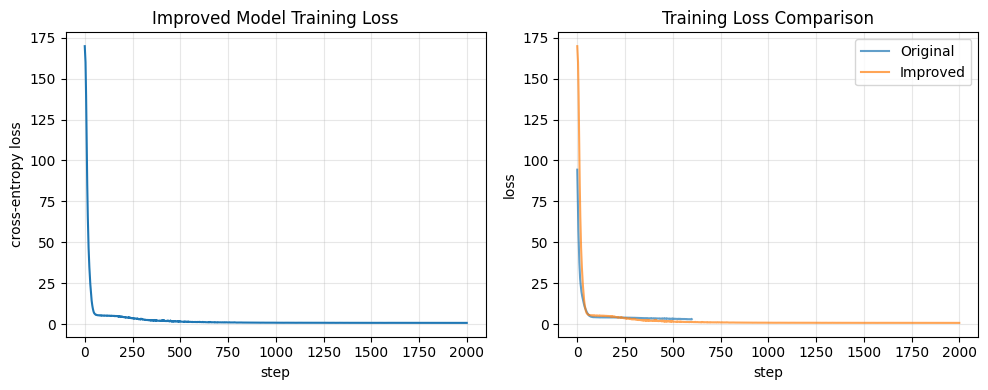

In [ ]:

# Plot improved training
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(losses_improved)
plt.title("Improved Model Training Loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
# Compare with original
if len(losses) > 0:
    plt.plot(losses[:len(losses_improved)], label='Original', alpha=0.7)
plt.plot(losses_improved, label='Improved', alpha=0.7)
plt.title("Training Loss Comparison")
plt.xlabel("step")
plt.ylabel("loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



In [ ]:

# Test improved model
src_test, tgt_test = make_reverse_batch(batch_size=5, max_len=max_content_len_improved, vocab_size=vocab_size_improved, device=device)
pred_improved = greedy_decode(seq2seq_improved, src_test, max_new_tokens=max_content_len_improved + 2)

print("=" * 80)
print("IMPROVED MODEL PREDICTIONS:")
print("=" * 80)
for i in range(5):
    src_tokens = [t for t in src_test[i].tolist() if t != PAD]
    tgt_tokens = [t for t in tgt_test[i].tolist() if t not in [PAD]]
    pred_tokens = [t for t in pred_improved[i].tolist()]

    print(f"\nExample {i+1}:")
    print(f"  SRC:  {src_tokens}")
    print(f"  TGT:  {tgt_tokens}")
    print(f"  PRED: {pred_tokens}")

    # Check if correct (ignoring BOS/EOS/PAD)
    expected_rev = [BOS] + src_tokens[::-1] + [EOS]
    if pred_tokens[:len(expected_rev)] == expected_rev:
        print(f"  ✓ CORRECT!")
    else:
        print(f"  ✗ Wrong")



IMPROVED MODEL PREDICTIONS:

Example 1:
  SRC:  [39, 63, 10, 60, 22, 14]
  TGT:  [1, 14, 22, 60, 10, 63, 39, 2]
  PRED: [1, 14, 22, 60, 10, 63, 39, 2]
  ✓ CORRECT!

Example 2:
  SRC:  [57, 54, 23, 47]
  TGT:  [1, 47, 23, 54, 57, 2]
  PRED: [1, 47, 23, 54, 57, 2, 2, 2]
  ✓ CORRECT!

Example 3:
  SRC:  [61, 42, 63, 3, 6, 46]
  TGT:  [1, 46, 6, 3, 63, 42, 61, 2]
  PRED: [1, 46, 6, 3, 63, 42, 61, 2]
  ✓ CORRECT!

Example 4:
  SRC:  [11, 37, 60, 62, 11]
  TGT:  [1, 11, 62, 60, 37, 11, 2]
  PRED: [1, 11, 62, 60, 37, 11, 2, 2]
  ✓ CORRECT!

Example 5:
  SRC:  [37, 6, 18, 45, 38]
  TGT:  [1, 38, 45, 18, 6, 37, 2]
  PRED: [1, 38, 45, 18, 6, 37, 2, 2]
  ✓ CORRECT!


# 16. BERT: Bidirectional Encoder Representations from Transformers

BERT (Devlin et al., 2018) revolutionized NLP by using a **bidirectional encoder-only** Transformer.
<img src="bert_model.png" width="700" align="center"/>

### Key differences from GPT (decoder-only) and Seq2Seq:
- **No causal masking**: Each token can attend to all other tokens (bidirectional)
- **Encoder-only**: Uses only the encoder stack from the original Transformer
- **Pre-training objectives**:
  1. **Masked Language Modeling (MLM)**: Randomly mask 15% of tokens and predict them
  2. **Next Sentence Prediction (NSP)**: Predict if two sentences follow each other

### Why bidirectional?
- GPT can only use left context (causal)
- BERT sees full context (left + right)
- Better for understanding tasks (classification, QA, NER)


## 16.1 BERT Model Architecture

BERT uses:
- Token embeddings (vocabulary)
- Position embeddings (learned, not sinusoidal)
- Segment embeddings (to distinguish sentences in NSP task)
- Stack of bidirectional encoder layers
- MLM head to predict masked tokens

We'll simplify by skipping NSP and segment embeddings for this toy example.


In [ ]:

class BERTModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=256,
                 n_layers=4, max_len=512, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len

        # Embeddings
        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)  # Learned positions (unlike sinusoidal)
        self.dropout = nn.Dropout(dropout)

        # Encoder layers (reuse TransformerEncoderLayer from before)
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)

        # MLM head
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )

    def forward(self, input_ids, mask=None, return_hidden=False):
        """
        input_ids: (B, T) token indices
        mask: (B, 1, 1, T) or None - padding mask (no causal mask for BERT!)
        """
        B, T = input_ids.shape
        assert T <= self.max_len

        # Create position ids
        pos_ids = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, -1)

        # Embeddings
        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)
        x = self.dropout(x)

        # Apply encoder layers (NO causal mask - this is bidirectional!)
        for layer in self.layers:
            x = layer(x, src_mask=mask)

        x = self.ln_f(x)

        # MLM predictions
        logits = self.mlm_head(x)

        if return_hidden:
            return logits, x
        return logits



## 16.2 Masked Language Modeling (MLM)

The MLM task:
1. Take a sequence of tokens
2. Randomly mask 15% of them (replace with [MASK] token)
3. Train model to predict the original tokens at masked positions
4. Loss is computed only on masked positions

Special tokens:
- `[PAD]` = 0
- `[MASK]` = 1
- `[CLS]` = 2 (classification token, placed at start)
- `[SEP]` = 3 (separator, placed at end)
- Regular tokens start at 4


In [ ]:

# Special tokens for BERT
PAD_BERT, MASK, CLS, SEP = 0, 1, 2, 3

def create_mlm_batch(batch_size, seq_len, vocab_size, mask_prob=0.15, device="cpu"):
    """
    Create a batch for Masked Language Modeling.

    Returns:
        input_ids: (B, T) with some tokens replaced by [MASK]
        labels: (B, T) with -100 for non-masked positions, original token for masked positions
        attention_mask: (B, 1, 1, T) padding mask
    """
    # Generate random sequences
    # [CLS] + content + [SEP] + padding
    input_ids = torch.full((batch_size, seq_len), PAD_BERT, dtype=torch.long, device=device)

    for i in range(batch_size):
        # Random content length
        content_len = random.randint(5, seq_len - 3)

        # [CLS]
        input_ids[i, 0] = CLS

        # Content tokens (start from 4 to avoid special tokens)
        content = torch.randint(4, vocab_size, (content_len,), device=device)
        input_ids[i, 1:1+content_len] = content

        # [SEP]
        input_ids[i, 1+content_len] = SEP

    # Create labels (copy of input_ids, will be masked)
    labels = input_ids.clone()

    # Create mask: which tokens to mask
    # Don't mask [PAD], [CLS], [SEP]
    special_tokens_mask = (input_ids == PAD_BERT) | (input_ids == CLS) | (input_ids == SEP)

    # Random masking
    probability_matrix = torch.full(input_ids.shape, mask_prob, device=device)
    probability_matrix.masked_fill_(special_tokens_mask, value=0.0)
    masked_indices = torch.bernoulli(probability_matrix).bool()

    # Set labels to -100 for non-masked tokens (ignore in loss)
    labels[~masked_indices] = -100

    # Replace masked tokens with [MASK]
    input_ids[masked_indices] = MASK

    # Create attention mask (1 for real tokens, 0 for padding)
    attention_mask = (input_ids != PAD_BERT).unsqueeze(1).unsqueeze(2).to(torch.uint8)

    return input_ids, labels, attention_mask

# Test the data generation
test_input, test_labels, test_mask = create_mlm_batch(2, 20, 64, mask_prob=0.15, device=device)
print("Input IDs (with [MASK]):")
print(test_input)
print("\nLabels (-100 = ignore, else = original token):")
print(test_labels)
print("\nMasked positions:")
print((test_labels != -100).long())



Input IDs (with [MASK]):
tensor([[ 2, 27, 13, 22, 34,  1, 31, 46, 20, 52, 45,  1, 21, 21, 58,  3,  0,  0,
          0,  0],
        [ 2,  7, 13,  4, 48,  1,  1, 54,  1, 61,  4, 39, 32,  9,  3,  0,  0,  0,
          0,  0]], device='cuda:0')

Labels (-100 = ignore, else = original token):
tensor([[-100, -100, -100, -100, -100,   57, -100, -100, -100, -100, -100,   61,
         -100, -100, -100, -100, -100, -100, -100, -100],
        [-100, -100, -100, -100, -100,   46,   17, -100,   16, -100, -100, -100,
         -100, -100, -100, -100, -100, -100, -100, -100]], device='cuda:0')

Masked positions:
tensor([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
       device='cuda:0')


## 16.3 Training BERT on MLM Task

Now we'll train a small BERT model to predict masked tokens.


In [ ]:

# Initialize BERT model
vocab_size_bert = 128
bert = BERTModel(
    vocab_size=vocab_size_bert,
    d_model=128,
    n_heads=8,
    d_ff=512,
    n_layers=4,
    max_len=128,
    dropout=0.1
).to(device)

opt_bert = torch.optim.AdamW(bert.parameters(), lr=5e-4, weight_decay=0.01)

print(f"BERT parameters: {sum(p.numel() for p in bert.parameters())/1e6:.2f}M")



BERT parameters: 0.86M


In [ ]:

# Training loop for MLM
steps_bert = 1000
losses_bert = []
bert.train()

for step in range(steps_bert):
    # Generate batch
    input_ids, labels, attention_mask = create_mlm_batch(
        batch_size=64,
        seq_len=32,
        vocab_size=vocab_size_bert,
        mask_prob=0.15,
        device=device
    )

    # Forward pass
    logits = bert(input_ids, mask=attention_mask)

    # Compute loss only on masked positions
    loss = F.cross_entropy(
        logits.reshape(-1, vocab_size_bert),
        labels.reshape(-1),
        ignore_index=-100  # Ignore non-masked positions
    )

    # Backward pass
    opt_bert.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(bert.parameters(), 1.0)
    opt_bert.step()

    losses_bert.append(loss.item())

    if (step + 1) % 100 == 0:
        print(f"step {step+1}/{steps_bert} | MLM loss {loss.item():.4f} | ppl {math.exp(loss.item()):.2f}")



step 100/1000 | MLM loss 4.8344 | ppl 125.76
step 200/1000 | MLM loss 4.8699 | ppl 130.31
step 300/1000 | MLM loss 4.8550 | ppl 128.39
step 400/1000 | MLM loss 4.8304 | ppl 125.26
step 500/1000 | MLM loss 4.8177 | ppl 123.67
step 600/1000 | MLM loss 4.8250 | ppl 124.58
step 700/1000 | MLM loss 4.8212 | ppl 124.11
step 800/1000 | MLM loss 4.8141 | ppl 123.23
step 900/1000 | MLM loss 4.8259 | ppl 124.70
step 1000/1000 | MLM loss 4.8370 | ppl 126.09


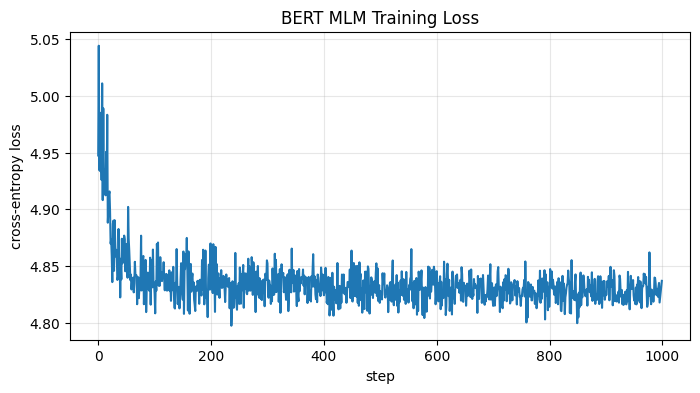

In [ ]:

# Plot training loss
plt.figure(figsize=(8, 4))
plt.plot(losses_bert)
plt.title("BERT MLM Training Loss")
plt.xlabel("step")
plt.ylabel("cross-entropy loss")
plt.grid(True, alpha=0.3)
plt.show()



## 16.4 Evaluating BERT: Predicting Masked Tokens

Let's see how well BERT can predict masked tokens. We'll create some test examples and visualize the predictions.


In [ ]:

@torch.no_grad()
def predict_masked_tokens(model, input_ids, attention_mask):
    """
    Predict tokens at [MASK] positions.
    Returns the input with [MASK] replaced by predictions.
    """
    model.eval()
    logits = model(input_ids, mask=attention_mask)
    predictions = torch.argmax(logits, dim=-1)

    # Replace [MASK] with predictions
    output = input_ids.clone()
    mask_positions = (input_ids == MASK)
    output[mask_positions] = predictions[mask_positions]

    return output, predictions

# Create test examples
bert.eval()
test_input, test_labels, test_mask = create_mlm_batch(
    batch_size=5,
    seq_len=24,
    vocab_size=vocab_size_bert,
    mask_prob=0.20,  # More masks for visualization
    device=device
)

# Get predictions
predicted_ids, all_preds = predict_masked_tokens(bert, test_input, test_mask)

# Display results
print("=" * 80)
print("BERT MLM PREDICTIONS:")
print("=" * 80)

for i in range(5):
    # Find the actual sequence (before padding)
    seq_len = (test_input[i] != PAD_BERT).sum().item()

    input_seq = test_input[i, :seq_len].tolist()
    pred_seq = predicted_ids[i, :seq_len].tolist()
    label_seq = test_labels[i, :seq_len].tolist()

    print(f"\nExample {i+1}:")
    print(f"  Input (w/ [MASK]):  {input_seq}")
    print(f"  Predicted:          {pred_seq}")
    print(f"  Original:           ", end="")

    # Show original tokens (from labels, replace -100 with predicted for display)
    original = []
    correct = 0
    total_masked = 0
    for j, (inp, pred, label) in enumerate(zip(input_seq, pred_seq, label_seq)):
        if label != -100:  # This was masked
            original.append(label)
            total_masked += 1
            if pred == label:
                correct += 1
        else:
            original.append(inp)

    print(original)

    if total_masked > 0:
        accuracy = 100.0 * correct / total_masked
        print(f"  Masked tokens: {total_masked}, Correct: {correct} ({accuracy:.1f}%)")



BERT MLM PREDICTIONS:

Example 1:
  Input (w/ [MASK]):  [2, 103, 1, 43, 68, 28, 3]
  Predicted:          [2, 103, 75, 43, 68, 28, 3]
  Original:           [2, 103, 55, 43, 68, 28, 3]
  Masked tokens: 1, Correct: 0 (0.0%)

Example 2:
  Input (w/ [MASK]):  [2, 114, 108, 1, 40, 49, 112, 30, 1, 60, 1, 1, 44, 114, 9, 103, 85, 3]
  Predicted:          [2, 114, 108, 73, 40, 49, 112, 30, 82, 60, 73, 73, 44, 114, 9, 103, 85, 3]
  Original:           [2, 114, 108, 6, 40, 49, 112, 30, 21, 60, 45, 13, 44, 114, 9, 103, 85, 3]
  Masked tokens: 4, Correct: 0 (0.0%)

Example 3:
  Input (w/ [MASK]):  [2, 106, 105, 68, 116, 75, 1, 84, 3]
  Predicted:          [2, 106, 105, 68, 116, 75, 82, 84, 3]
  Original:           [2, 106, 105, 68, 116, 75, 44, 84, 3]
  Masked tokens: 1, Correct: 0 (0.0%)

Example 4:
  Input (w/ [MASK]):  [2, 55, 78, 1, 107, 57, 3]
  Predicted:          [2, 55, 78, 73, 107, 57, 3]
  Original:           [2, 55, 78, 28, 107, 57, 3]
  Masked tokens: 1, Correct: 0 (0.0%)

Example 5:
  I

## 16.5 Visualizing BERT Attention

Let's visualize how BERT's bidirectional attention differs from GPT's causal attention.


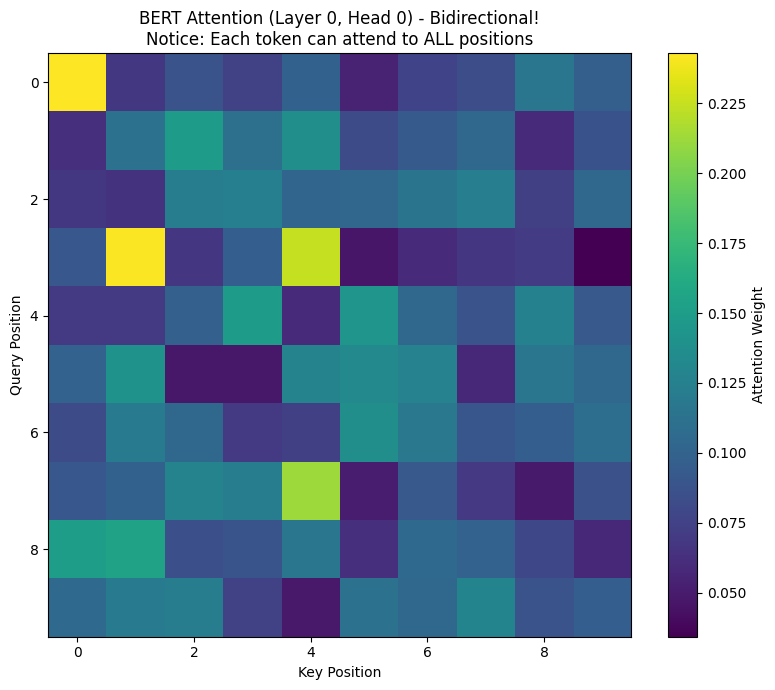


Input sequence (length 10):
[2, 45, 66, 1, 87, 76, 51, 99, 88, 3]

Key observation: Unlike GPT's triangular pattern, BERT attention is FULL!
Every position can attend to every other position (bidirectional).


In [ ]:

# Modified BERT to return attention
class BERTModelWithAttention(nn.Module):
    def __init__(self, vocab_size, d_model=128, n_heads=4, d_ff=256,
                 n_layers=4, max_len=512, dropout=0.1):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_len = max_len

        self.token_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(max_len, d_model)
        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, n_heads, d_ff, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.mlm_head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.LayerNorm(d_model),
            nn.Linear(d_model, vocab_size)
        )

    def forward(self, input_ids, mask=None, return_attention=False):
        B, T = input_ids.shape
        pos_ids = torch.arange(T, device=input_ids.device).unsqueeze(0).expand(B, -1)

        x = self.token_emb(input_ids) + self.pos_emb(pos_ids)
        x = self.dropout(x)

        attentions = []
        for layer in self.layers:
            if return_attention:
                x, attn = layer(x, src_mask=mask, return_attn=True)
                attentions.append(attn)
            else:
                x = layer(x, src_mask=mask)

        x = self.ln_f(x)
        logits = self.mlm_head(x)

        if return_attention:
            return logits, attentions
        return logits

# Copy weights from trained BERT
bert_with_attn = BERTModelWithAttention(
    vocab_size=vocab_size_bert,
    d_model=128,
    n_heads=8,
    d_ff=512,
    n_layers=4,
    max_len=128,
    dropout=0.1
).to(device)

# Copy weights
bert_with_attn.load_state_dict(bert.state_dict())
bert_with_attn.eval()

# Get attention for a sample
sample_input, _, sample_mask = create_mlm_batch(1, 20, vocab_size_bert, mask_prob=0.15, device=device)
logits, attentions = bert_with_attn(sample_input, mask=sample_mask, return_attention=True)

# Visualize first layer, first head
attn_map = attentions[0][0, 0].detach().cpu().numpy()  # (T, T)
seq_len = (sample_input[0] != PAD_BERT).sum().item()
attn_map = attn_map[:seq_len, :seq_len]

plt.figure(figsize=(8, 7))
plt.imshow(attn_map, cmap='viridis', aspect='auto')
plt.colorbar(label='Attention Weight')
plt.title("BERT Attention (Layer 0, Head 0) - Bidirectional!\nNotice: Each token can attend to ALL positions")
plt.xlabel("Key Position")
plt.ylabel("Query Position")
plt.tight_layout()
plt.show()

print(f"\nInput sequence (length {seq_len}):")
print(sample_input[0, :seq_len].tolist())
print("\nKey observation: Unlike GPT's triangular pattern, BERT attention is FULL!")
print("Every position can attend to every other position (bidirectional).")



## 16.6 BERT vs GPT: Key Differences Summary

Let's compare the three Transformer variants we've implemented:

| Feature | **GPT** (Decoder-only) | **BERT** (Encoder-only) | **Seq2Seq** (Enc-Dec) |
|---------|------------------------|-------------------------|------------------------|
| **Architecture** | Decoder stack only | Encoder stack only | Encoder + Decoder |
| **Attention** | Causal (masked) | Bidirectional (full) | Both types |
| **Masking** | Lower-triangular | No causal mask | Causal in decoder |
| **Training** | Next-token prediction | Masked token prediction | Sequence-to-sequence |
| **Use cases** | Text generation | Understanding, classification | Translation, summarization |
| **Context** | Left-only | Full (left + right) | Source + partial target |
| **Position Encoding** | Usually sinusoidal | Learned embeddings | Usually sinusoidal |

### When to use which?
- **GPT**: Text generation, completion, creative writing
- **BERT**: Classification, NER, QA, sentence embeddings
- **Seq2Seq**: Translation, summarization, any input→output task
